
# Entropy of Class Labels and Predictive Entropy (PyTorch Version)

This notebook illustrates how **entropy** appears in a simple classification
setting, using the MNIST handwritten digits dataset:

- We compute the **empirical class entropy** \(H(Y)\) in bits.
- We train a small **neural network classifier** in PyTorch.
- We evaluate the **predictive entropy** of the model's output distribution on the test set.
- We visualize:
  - A histogram of predictive entropies;
  - Grids of **most confident** (lowest entropy) and **least confident** (highest entropy) predictions.

All figures are saved into a local `figs/` directory.


In [1]:

# -------------------------------------------------------------
# Imports and basic setup
# -------------------------------------------------------------

import os
os.makedirs("figs", exist_ok=True)

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



## 1. Load MNIST and Compute Class Entropy

We load the MNIST dataset (train + test) and compute the empirical
distribution of class labels \(Y \in \{0,\dots,9\}\). The **entropy**
\[
H(Y) = -\sum_y p(y)\,\log_2 p(y)
\]
quantifies the uncertainty in the class labels.


In [2]:

# -------------------------------------------------------------
# Load MNIST (train + test) and compute empirical class entropy
# -------------------------------------------------------------

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

all_labels = np.concatenate([train_dataset.targets.numpy(), test_dataset.targets.numpy()])
num_classes = 10

counts = np.bincount(all_labels, minlength=num_classes)
probs = counts / counts.sum()

eps = 1e-12
entropy_bits = -np.sum(probs * np.log2(probs + eps))

print("Class counts:", counts)
print("Class probabilities:", probs)
print(f"Empirical class entropy H(Y): {entropy_bits:.4f} bits")


Class counts: [6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]
Class probabilities: [0.09861429 0.11252857 0.09985714 0.10201429 0.09748571 0.09018571
 0.09822857 0.10418571 0.0975     0.0994    ]
Empirical class entropy H(Y): 3.3198 bits



## 2. Define and Train a Small Neural Network Classifier

We define a simple fully-connected neural network:

- Input: \(28\times 28 = 784\) pixels (flattened).
- One hidden layer with ReLU.
- Output: 10 logits (one per class), converted to probabilities via softmax.

We train with cross-entropy loss for a few epochs.


In [3]:

# -------------------------------------------------------------
# Define a simple MLP classifier in PyTorch
# -------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        # x is (batch_size, 1, 28, 28)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleMLP().to(device)

# Data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -------------------------------------------------------------
# Training loop (a few epochs)
# -------------------------------------------------------------
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Epoch {epoch:2d}/{num_epochs} - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")


Using device: cpu
Epoch  1/3 - Loss: 0.3600, Acc: 0.9031
Epoch  2/3 - Loss: 0.1555, Acc: 0.9552
Epoch  3/3 - Loss: 0.1065, Acc: 0.9689



## 3. Predictive Entropy on the Test Set

For each test image, the neural network produces a probability vector
$\hat{p}(Y \mid X)$ over the 10 classes. The **predictive entropy** is
$$
H\bigl(\hat{p}(\cdot \mid X)\bigr)
  = -\sum_{y} \hat{p}(y \mid X)\,\log_2 \hat{p}(y \mid X).
$$

- Low entropy: the model is very *confident* (peaked distribution).
- High entropy: the model is *uncertain* (spread-out distribution).


In [4]:

# -------------------------------------------------------------
# Compute predictive entropies on the test set
# -------------------------------------------------------------

model.eval()
all_probs = []
all_labels_test = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs_batch = F.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs_batch)
        all_labels_test.append(labels.numpy())

all_probs = np.concatenate(all_probs, axis=0)          # shape (N_test, 10)
all_labels_test = np.concatenate(all_labels_test, axis=0)

eps = 1e-12
predictive_entropy = -np.sum(all_probs * np.log2(all_probs + eps), axis=1)

print("Predictive entropy statistics (in bits):")
print("  min :", predictive_entropy.min())
print("  max :", predictive_entropy.max())
print("  mean:", predictive_entropy.mean())


Predictive entropy statistics (in bits):
  min : 1.4541113e-06
  max : 2.8881607
  mean: 0.18292145



### 3.1 Histogram of Predictive Entropies

We now plot a histogram of predictive entropies over the test set.
This reveals the distribution of the model's confidence.


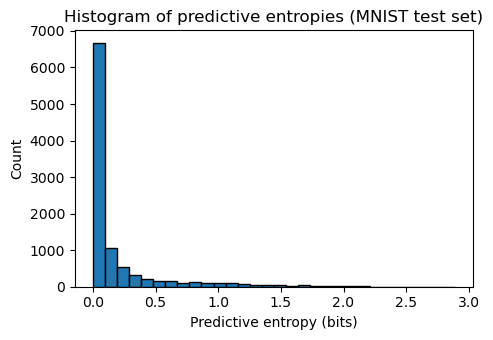

Saved histogram to figs/entropy_predictive_hist.png


In [5]:

# -------------------------------------------------------------
# Plot histogram of predictive entropies
# -------------------------------------------------------------

plt.figure(figsize=(5, 3.5))
plt.hist(predictive_entropy, bins=30, edgecolor="black")
plt.xlabel("Predictive entropy (bits)")
plt.ylabel("Count")
plt.title("Histogram of predictive entropies (MNIST test set)")
plt.tight_layout()
plt.savefig("figs/entropy_predictive_hist.png", dpi=150)
plt.show()

print("Saved histogram to figs/entropy_predictive_hist.png")



## 4. Visualizing Most Confident and Least Confident Predictions

We select:

- The 25 test images with the **lowest** predictive entropy;
- The 25 test images with the **highest** predictive entropy;

and display them in $5 \times 5$ grids. Each image is annotated with:

- The predicted class;
- The predictive entropy (in bits).


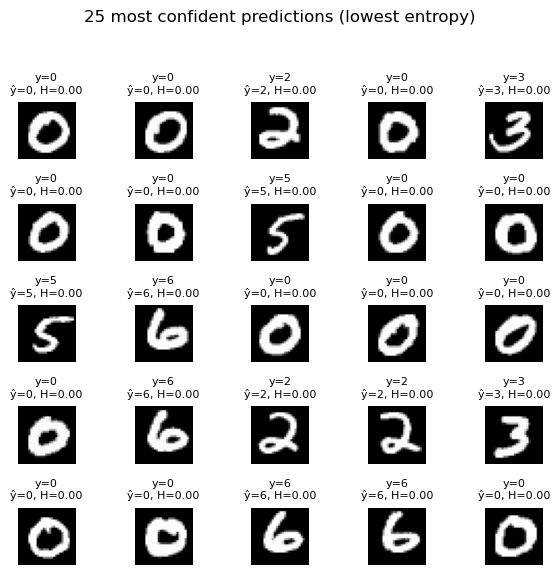

Saved grid to figs/entropy_low_confidence_grid.png


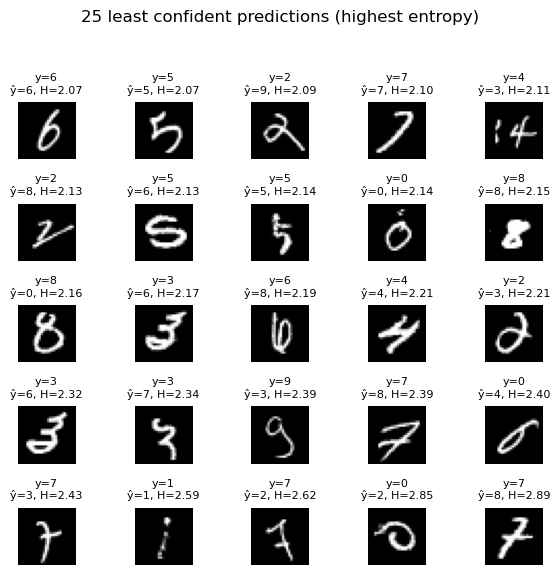

Saved grid to figs/entropy_high_confidence_grid.png


In [6]:

# -------------------------------------------------------------
# Helper to plot a 5x5 grid of images
# -------------------------------------------------------------

def plot_grid(images, labels, entropies, preds, title, filename):
    plt.figure(figsize=(6, 6))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        img = images[i].squeeze()  # (28, 28)
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        ax.set_title(f"y={labels[i]}\nŷ={preds[i]}, H={entropies[i]:.2f}",
                     fontsize=8)
    plt.suptitle(title, fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, dpi=150)
    plt.show()
    print(f"Saved grid to {filename}")


# -------------------------------------------------------------
# Extract indices of lowest / highest entropy
# -------------------------------------------------------------

N = predictive_entropy.shape[0]
sorted_idx = np.argsort(predictive_entropy)

# Lowest 25 entropies
low_idx = sorted_idx[:25]
# Highest 25 entropies
high_idx = sorted_idx[-25:]

# We need the corresponding images; easiest is to rebuild them from test_dataset
# using the same indices.
all_images_test = test_dataset.data.numpy() / 255.0  # shape (N_test, 28, 28)
all_labels_test_int = test_dataset.targets.numpy()

# Predicted classes:
preds_test = all_probs.argmax(axis=1)

# Prepare data for grids
low_images  = all_images_test[low_idx]
low_labels  = all_labels_test_int[low_idx]
low_ent     = predictive_entropy[low_idx]
low_preds   = preds_test[low_idx]

high_images = all_images_test[high_idx]
high_labels = all_labels_test_int[high_idx]
high_ent    = predictive_entropy[high_idx]
high_preds  = preds_test[high_idx]

plot_grid(low_images, low_labels, low_ent, low_preds,
          "25 most confident predictions (lowest entropy)",
          "figs/entropy_low_confidence_grid.png")

plot_grid(high_images, high_labels, high_ent, high_preds,
          "25 least confident predictions (highest entropy)",
          "figs/entropy_high_confidence_grid.png")
